In [3]:
from ultralytics import YOLO

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [5]:
import torch

In [6]:
from tqdm import tqdm

In [7]:
import SimpleITK as sitk
import cv2

In [8]:
from IPython.display import display, clear_output
import time

In [9]:
import os
import json

# Описание датасета

Датасет состоит из 489 кейсов (0 - 299, 400 - 588).
Каждый кейс содержит:
1. imaging.nii.gz - трехмерное изображение почек
2. segmentation.nii.gz - трехмерное изображение маски (0 - фон, 1 - почка, 2 - опухоль, 3 - киста)
3. instances - папка, которая содержит все маски по отдельности трижды (зачем трижды?). Они представляют собой маски, где 0 - фон, а 1 - объект данного класса).

Принято решение брать первую аннотацию.

In [11]:
path = "D:\kits23\dataset"
cases1 = list(range(300))
cases2 = list(range(400, 589))
categories = [
    {"id": 0, "name": "kidney", "supercategory": ""},
    {"id": 1, "name": "tumor", "supercategory": ""},
    {"id": 2, "name": "cyst", "supercategory": ""}]

### Методы в помощь

In [12]:
def get_contour_coords(mask):
    """
    Extracts contour coordinates from a segmentation mask.

    Args:
        mask (2d np.array): A binary mask representing the segmentation of an object.

    Returns:
        str: A string containing normalized coordinates of the contours.
    """
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    normalized_coordinates = []
    
    for contour in contours:
        normalized_contour = contour.squeeze() / mask.shape[::-1]
        normalized_coordinates.extend(normalized_contour.flatten().tolist())
    
    coordinates_string = ' '.join(map(str, normalized_coordinates))
    
    return coordinates_string

In [13]:
def get_instances_description(curr_case):
    """
    Get a list of dictionaries describing instances for the given case.

    Args:
        curr_case (int): The current case number.

    Returns:
        list: A list of dictionaries, each describing an instance with keys 'obj_name', 'instance', and 'annotation'.
    """
    curr_path = path + "\\case_00" + str(curr_case).zfill(3) + "\\instances"
    objects = os.listdir(curr_path)
    
    obj_list = []

    for obj in objects:

        obj_name, instance, annotation = obj.split('_')
        _, instance_num = instance.split('-')
        _, annotation_tail = annotation.split('-')
        annotation_num, _, _ = annotation_tail.split('.')

        obj_dict = {}
        obj_dict.update({"obj_name": obj_name})
        obj_dict.update({"instance": int(instance_num)})
        obj_dict.update({"annotation": int(annotation_num)})
        
        obj_list.append(obj_dict)

    return obj_list

In [14]:
def compare_arrays(arr1, arr2):
    """
    Сравнивает два трехмерных массива и находит слои несоответствия.
    
    Аргументы:
        arr1 (np.array): Трехмерный массив 512x512xN, где N - размерность третьего измерения
        arr2 (np.array): Трехмерный массив 512x512xN, где N - размерность третьего измерения
    
    Возвращает:
        list: Список слоёв, который отличается между собой
    """
    different_layers = []
    
    # Проверяем каждый слой массивов на равенство
    for i in range(arr1.shape[2]):
        if not np.array_equal(arr1[:, :, i], arr2[:, :, i]):
            different_layers.append(i)
    
    return different_layers

In [15]:
def get_3d_array_from_path(curr_path):
    curr = sitk.ReadImage(curr_path)
    curr_array = sitk.GetArrayFromImage(curr)
    return curr_array

In [16]:
def get_id(case, layer):
    return str(case).zfill(3) + str(layer).zfill(3)

In [17]:
def save_text_to_file(text, file_path):
    with open(file_path, "w") as file:
        file.write(text)

### Начало сборки масок

Case: 131
instances [{'obj_name': 'kidney', 'instance': 1, 'annotation': 1}, {'obj_name': 'kidney', 'instance': 1, 'annotation': 2}, {'obj_name': 'kidney', 'instance': 1, 'annotation': 3}, {'obj_name': 'kidney', 'instance': 2, 'annotation': 1}, {'obj_name': 'kidney', 'instance': 2, 'annotation': 2}, {'obj_name': 'kidney', 'instance': 2, 'annotation': 3}, {'obj_name': 'tumor', 'instance': 1, 'annotation': 1}, {'obj_name': 'tumor', 'instance': 1, 'annotation': 2}, {'obj_name': 'tumor', 'instance': 1, 'annotation': 3}]
instance {'obj_name': 'kidney', 'instance': 1, 'annotation': 1}
category_name kidney category_id 0
instance {'obj_name': 'kidney', 'instance': 2, 'annotation': 1}
category_name kidney category_id 0
instance {'obj_name': 'tumor', 'instance': 1, 'annotation': 1}
category_name tumor category_id 1
Case: 132
instances [{'obj_name': 'kidney', 'instance': 1, 'annotation': 1}, {'obj_name': 'kidney', 'instance': 1, 'annotation': 2}, {'obj_name': 'kidney', 'instance': 1, 'annotation'

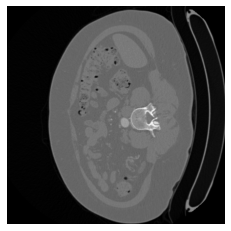

In [41]:
for case in range(131, 136):
# for case in cases1: # Раскомментировать здесь, чтобы скачать первую партию изображений
    
    print("Case:", str(case).zfill(3))
    
    # Получение 3D-изображения
    image_path = path + "\\case_00" + str(case).zfill(3) + "\\imaging.nii.gz"
    image_array = get_3d_array_from_path(image_path)
    
    # Получение 3D-маски
    mask_path = path + "\\case_00" + str(case).zfill(3) + "\\segmentation.nii.gz"
    mask_array = get_3d_array_from_path(mask_path)
    
    case_shape = image_array.shape[2]
    
    # Получение словаря, в котором хранятся все маски для каждого класса по отдельности (см. метод выше)
    instances = get_instances_description(case)
    print("instances", instances)
    
    # Получение 3D-масок по экземплярам
    instances_list = []   # Список с 3D-масками экземляров
    instance_cats = []    # Список с соответствующим классом в виде числа
    for instance in instances:
        if instance['annotation'] == 1:
            print("instance", instance)
            
            # Определение id и типа текущего экземляра
            category_name = instance['obj_name']
            for category in categories:
                if category["name"] == category_name:
                    category_id = category["id"]
                    break
            print("category_name", category_name, "category_id", category_id)
            
            # Получение 3D-экземляра
            instance_path = path + "\\case_00" + str(case).zfill(3) + \
            "\\instances\\" + category_name               + \
            "_instance-"    + str(instance['instance'])   + \
            "_annotation-"  + str(instance['annotation']) + ".nii.gz"
            instance_array = get_3d_array_from_path(instance_path)
            
            # Добавление во временные списки
            instance_cats.append(category_id)
            instances_list.append(instance_array)
    
    # Сохранение изображений и лейблов кейса
    images_saved = 0
    for layer in range(case_shape):
        
        image_2d = image_array[:, :, layer]
        mask_2d = mask_array[:, :, layer]
        
        # Если на 2D-маске нет ни одного класса, то изображение не сохраняется
        if np.all(mask_2d == 0):
            continue
        
        contours = ""
        for i, category in enumerate(instance_cats):
            contour = get_contour_coords(instances_list[i][layer])
            if contour:
                contours += str(category) + " " + contour + '\n'
            
             
        if contours:
            # Сохранение лейбла
            save_text_to_file(contours[:-1], r"D:\datasets\my project\train\labels\img_" + get_id(case, layer) + ".txt")
            
            # Сохранение изображения
            plt.imshow(image_2d, cmap='gray')
            plt.axis('off')
            # plt.show()
            plt.imsave(r"D:\datasets\my project\train\images\img_" + get_id(case, layer) + ".png", image_2d, cmap='gray') 
    

In [43]:
model = YOLO('yolov8n-seg.pt')
results = model.train(data=r"D:\datasets\my project\data.yaml", epochs=10, imgsz=640)

Ultralytics YOLOv8.1.47  Python-3.9.12 torch-2.0.1+cpu CPU (Intel Core(TM) i3-8130U 2.20GHz)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=D:\datasets\my project\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

train: Scanning D:\datasets\my project\train\labels.cache... 1154 images, 0 backgrounds, 1 corrupt: 100%|██████████| 11

train: WARNING  D:\datasets\my project\train\images\img_091209.png: ignoring corrupt image/label: labels require 5 columns, 3 columns detected



val: Scanning D:\datasets\my project\train\labels.cache... 1154 images, 0 backgrounds, 1 corrupt: 100%|██████████| 1154

train: WARNING  D:\datasets\my project\train\images\img_091209.png: ignoring corrupt image/label: labels require 5 columns, 3 columns detected
Plotting labels to C:\Users\Acer\runs\segment\train9\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to C:\Users\Acer\runs\segment\train9
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      2.846      4.711      5.579      2.506          1        640: 100%|██████████| 73/73 [20:49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all       1153       1435    0.00227      0.161    0.00644    0.00149    0.00102     0.0725   0.000701   0.000118

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      2.296      4.059      3.928      1.995          1        640: 100%|██████████| 73/73 [22:48
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all       1153       1435      0.728     0.0513      0.041     0.0157       0.72     0.0409     0.0342    0.00964

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      2.115      3.869      3.146       1.84          1        640: 100%|██████████| 73/73 [25:58
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all       1153       1435      0.785      0.099       0.13      0.066      0.772     0.0888      0.102     0.0291

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.897      3.623      2.541      1.692          1        640: 100%|██████████| 73/73 [21:31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all       1153       1435      0.643      0.138      0.152     0.0658      0.619      0.128      0.125     0.0395

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.719      3.359       2.07      1.546          1        640: 100%|██████████| 73/73 [22:38
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all       1153       1435      0.482      0.412      0.395       0.21      0.469      0.377      0.358      0.152

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.562      3.072      1.726       1.44          1        640: 100%|██████████| 73/73 [22:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all       1153       1435      0.597      0.488      0.524       0.29      0.582      0.459      0.499      0.213

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.423      2.862      1.427      1.334          1        640: 100%|██████████| 73/73 [21:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1153       1435      0.653      0.492      0.535      0.294      0.648      0.487      0.524      0.253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.311       2.71      1.266      1.262          1        640: 100%|██████████| 73/73 [21:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1153       1435      0.783      0.544      0.594      0.359      0.764      0.532      0.579      0.297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G       1.17      2.475      1.128      1.176          1        640: 100%|██████████| 73/73 [22:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1153       1435      0.746      0.579      0.616      0.396      0.744      0.578      0.611      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.061      2.284      0.982      1.114          1        640: 100%|██████████| 73/73 [21:49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1153       1435      0.837      0.608      0.653      0.428      0.822      0.615      0.647      0.368



10 epochs completed in 5.469 hours.
Optimizer stripped from C:\Users\Acer\runs\segment\train9\weights\last.pt, 6.8MB
Optimizer stripped from C:\Users\Acer\runs\segment\train9\weights\best.pt, 6.8MB

Validating C:\Users\Acer\runs\segment\train9\weights\best.pt...
Ultralytics YOLOv8.1.47  Python-3.9.12 torch-2.0.1+cpu CPU (Intel Core(TM) i3-8130U 2.20GHz)
YOLOv8n-seg summary (fused): 195 layers, 3258649 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all       1153       1435      0.838      0.607      0.652      0.427      0.823      0.614      0.646      0.367
                kidney       1153       1141      0.936      0.886      0.932      0.705      0.917      0.879      0.917      0.591
                 tumor       1153        191      0.752      0.487      0.564      0.313      0.728      0.505      0.563      0.256
                  cyst       1153        103      0.826      0.447      0.459      0.264      0.823      0.456      0.458      0.256
Speed: 3.4ms preprocess, 386.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to C:\Users\Acer\runs\segment\train9


In [10]:
model = YOLO(r"C:\Users\Acer\runs\segment\train9\weights\best.pt")

In [13]:
results = model(r"D:\datasets\my project\train\images\img_091179.png")  # return a list of Results objects

# Process results list
for result in results:
    # boxes = result.boxes  # Boxes object for bounding box outputs
    # masks = result.masks  # Masks object for segmentation masks outputs
    # keypoints = result.keypoints  # Keypoints object for pose outputs
    # probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen
    # result.save(filename='result.jpg')  # save to disk


image 1/1 D:\datasets\my project\train\images\img_091179.png: 640x640 1 kidney, 269.9ms
Speed: 6.0ms preprocess, 269.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
